# Modeling and Simulation in Python

Chapter 12

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import matplotlib.pyplot as plt
import numpy as np

### Code

Here's the code from the previous notebook that we'll need.

In [2]:
def get_first_label(series):
    """Get the first label of a pandas Series."""
    return series.index[0]
def get_last_label(series):
    """Get the first label of a pandas Series."""
    return series.index[-1]

def get_first_value(series):
    """Get the first value of a pandas Series."""
    return series.iloc[0]

def get_last_value(series):
    """Get the first value of a pandas Series."""
    return series.iloc[-1]

In [3]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [4]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    

    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
        
    
    return frame

### Metrics

Given the results, we can compute metrics that quantify whatever we are interested in, like the total number of sick students, for example.

In [6]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

Here's an example.|

In [7]:
beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))

0.333 0.25 0.4672800628126752


**Exercise:** Write functions that take a `TimeFrame` object as a parameter and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the `System` object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [8]:
# Solution goes here

def calc_peak_infected(results):
    return results.I.max()

In [9]:
# Solution goes here
def calc_peak_infected_day(results):
    return results.I.idxmax()

In [10]:
# Solution goes here
def sick_rate_at_end(results):
    return results.I.iloc[-1]

In [11]:
calc_peak_infected(results)

0.043536202687592354

In [12]:
calc_peak_infected_day(results)

30.0

In [13]:
sick_rate_at_end(results)

0.0006227767133270002

### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [14]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [15]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

namespace(init=S    0.988889
               I    0.011111
               R    0.000000
               Name: state, dtype: float64,
          t0=0,
          t_end=98,
          beta=0.3333333333333333,
          gamma=0.25)

And run the model without immunization.

In [16]:
results = run_simulation(system, update_func)
print(results)
calc_total_infected(results)

             S         I         R
0.0   0.988889  0.011111  0.000000
1.0   0.985226  0.011996  0.002778
2.0   0.981287  0.012936  0.005777
3.0   0.977055  0.013934  0.009011
4.0   0.972517  0.014988  0.012494
...        ...       ...       ...
95.0  0.520975  0.000845  0.478179
96.0  0.520829  0.000781  0.478391
97.0  0.520693  0.000721  0.478586
98.0  0.520568  0.000666  0.478766
99.0  0.520453  0.000615  0.478933

[100 rows x 3 columns]


0.46843634512145604

Now with 10% immunization.

In [17]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
print(system2)
results2 = run_simulation(system2, update_func)
print(results2)
calc_total_infected(results2)

System(init=S    0.888889
I    0.011111
R    0.100000
Name: state, dtype: float64, t0=0, t_end=98, beta=0.3333333333333333, gamma=0.25)
             S         I         R
0.0   0.888889  0.011111  0.100000
1.0   0.885597  0.011626  0.102778
2.0   0.882165  0.012151  0.105684
3.0   0.878592  0.012686  0.108722
4.0   0.874876  0.013230  0.111893
...        ...       ...       ...
95.0  0.583289  0.001648  0.415063
96.0  0.582969  0.001556  0.415475
97.0  0.582666  0.001469  0.415864
98.0  0.582381  0.001387  0.416232
99.0  0.582112  0.001310  0.416579

[100 rows x 3 columns]


0.3067773759158855

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

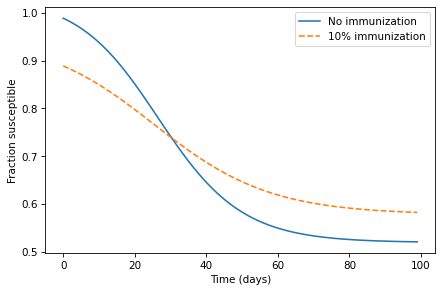

In [18]:
plt.plot(results.S, '-', label='No immunization')
plt.plot(results2.S, '--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

#savefig('figs/chap12-fig01.pdf')

Now we can sweep through a range of values for the fraction of the population who are immunized.

In [19]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    results = run_simulation(system, update_func)
    print(fraction, calc_total_infected(results))

0.0 0.46843634512145604
0.1 0.3067773759158855
0.2 0.1615972308618978
0.30000000000000004 0.0728630987250175
0.4 0.03552346936020401
0.5 0.01968883914021219
0.6000000000000001 0.011622061266293171
0.7000000000000001 0.006838737865016542
0.8 0.003696496254630366
0.9 0.0014815326722739525
1.0 -0.00016121210941241054


This function does the same thing and stores the results in a `Sweep` object.

In [20]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [21]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

Parameter
0.00    0.468436
0.05    0.387480
0.10    0.306777
0.15    0.229529
0.20    0.161597
0.25    0.108916
0.30    0.072863
0.35    0.049952
0.40    0.035523
0.45    0.026122
0.50    0.019689
0.55    0.015072
0.60    0.011622
0.65    0.008956
0.70    0.006839
0.75    0.005119
0.80    0.003696
0.85    0.002500
0.90    0.001482
0.95    0.000603
1.00   -0.000161
Name: Metric, dtype: float64

And here's what the results look like.

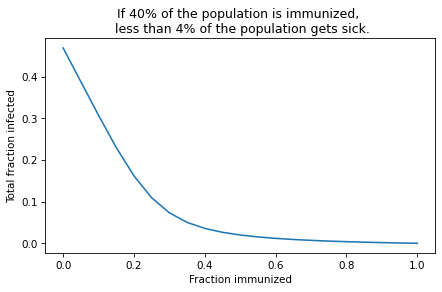

In [22]:
plt.plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='If 40% of the population is immunized, \n less than 4% of the population gets sick.')
         #legend=False)

#savefig('figs/chap12-fig02.pdf')

If 40% of the population is immunized, less than 4% of the population gets sick.

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [23]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [24]:
spending = linspace(0, 1200, 21)

array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200.])

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [25]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

[ 0.13385702  0.2425687   0.43762542  0.78331446  1.38276841  2.38405844
  3.95632223  6.20051038  9.00332005 11.9737532  14.62117157 16.6403677
 18.00499022 18.85351648 19.35409071 19.6402758  19.80096396 19.89027402
 19.93963167 19.96682398 19.98177898]


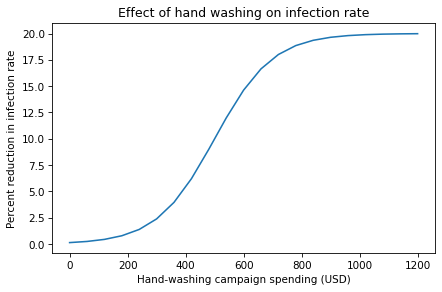

In [26]:
percent_reduction = compute_factor(spending) * 100
print(percent_reduction)

plt.plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate'
         )

**Exercise:** Modify the parameters `M`, `K`, and `B`, and see what effect they have on the shape of the curve.  Read about the [generalized logistic function on Wikipedia](https://en.wikipedia.org/wiki/Generalised_logistic_function).  Modify the other parameters and see what effect they have.

[ 0.94851746  1.66345393  2.8370213   4.62950433  7.08687388 10.
 12.91312612 15.37049567 17.1629787  18.33654607 19.05148254 19.46806013
 19.70451937 19.83674858 19.91007454 19.95054754 19.9728296  19.98507942
 19.99180866 19.99550366 19.99753211]


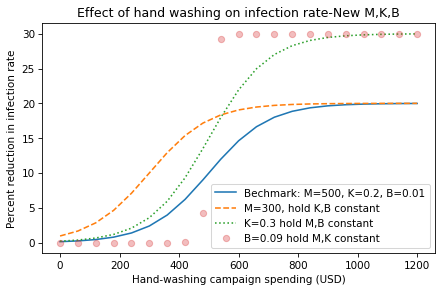

In [27]:
precent_reduction0 = logistic(spending, M=300, K=0.2, B=0.01)*100
precent_reduction1 = logistic(spending, M=500, K=0.3, B=0.01)*100
precent_reduction2 = logistic(spending, M=500, K=0.3, B=0.09)*100
print(precent_reduction0)
plt.plot(spending, percent_reduction,'-', label='Bechmark: M=500, K=0.2, B=0.01')
plt.plot(spending,precent_reduction0,'--', label='M=300, hold K,B constant')
plt.plot(spending,precent_reduction1,':', label='K=0.3 hold M,B constant')
plt.plot(spending,precent_reduction2,'o', alpha=0.3, label='B=0.09 hold M,K constant')
decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate-New M,K,B'
         )

M: controls the location of the transition, a smaller M, indicates less spending to reach the transition.

K: controls the upper bound , a higher K, shows more percent reduction

B: controls the steepness of the transition, a higher B, indicate a sharp break at the transition.

### Hand washing

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [28]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [29]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

Now we can sweep different levels of campaign spending.

In [30]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results))

0.0 0.3328871432717143 0.4668879069012737
100.0 0.3321342526691939 0.4642630122501804
200.0 0.33017160845482885 0.4573484110691278
300.0 0.32538647186519215 0.44004577194139716
400.0 0.3154039052420003 0.40185777057153715
500.0 0.3 0.33738498288362895
600.0 0.28459609475799963 0.2677540099103801
700.0 0.2746135281348078 0.22227817314437215
800.0 0.26982839154517113 0.20119876208634124
900.0 0.2678657473308061 0.19278590144114072
1000.0 0.26711285672828566 0.18960127383137504
1100.0 0.26683150821044227 0.18841764004225225
1200.0 0.26672740341296003 0.18798057687227443


Here's a function that sweeps a range of spending and stores the results in a `SweepSeries`.

In [31]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [32]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

Parameter
0.000000       0.466888
63.157895      0.465537
126.315789     0.463029
189.473684     0.458420
252.631579     0.450122
315.789474     0.435705
378.947368     0.412167
442.105263     0.377458
505.263158     0.333529
568.421053     0.288054
631.578947     0.250187
694.736842     0.223962
757.894737     0.207897
821.052632     0.198710
884.210526     0.193639
947.368421     0.190891
1010.526316    0.189415
1073.684211    0.188625
1136.842105    0.188205
1200.000000    0.187981
Name: Metric, dtype: float64

And here's what it looks like.

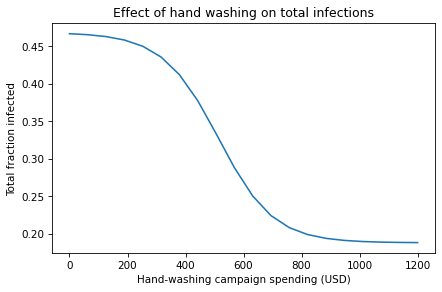

In [33]:
plt.plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections'
         )

#savefig('figs/chap12-fig03.pdf')

Now let's put it all together to make some public health spending decisions.

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [34]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.linspace(0, max_doses, max_doses+1, endpoint=True)
max_doses

12

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [35]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results = run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))

0.0 0.9888888888888889 0.26672740341296003 0.18798057687227443
1.0 0.9777777777777779 0.26683150821044227 0.1749332179598173
2.0 0.9666666666666667 0.26711285672828566 0.16323026892535375
3.0 0.9555555555555556 0.2678657473308061 0.15380081724382266
4.0 0.9444444444444445 0.26982839154517113 0.1488406716149695
5.0 0.9333333333333333 0.2746135281348078 0.15322837657945743
6.0 0.9222222222222223 0.28459609475799963 0.17528804249084784
7.0 0.9111111111111112 0.3 0.21770473418381664
8.0 0.9 0.3154039052420003 0.25941201224545773
9.0 0.888888888888889 0.32538647186519215 0.2787115299715025
10.0 0.8777777777777778 0.33017160845482885 0.2782106202567224
11.0 0.8666666666666667 0.3321342526691939 0.2676529400951123
12.0 0.8555555555555556 0.3328871432717143 0.25309423539892584


The following function wraps that loop and stores the results in a `Sweep` object.

In [36]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [37]:
infected_sweep = sweep_doses(dose_array)

Parameter
0     0.187981
1     0.174933
2     0.163230
3     0.153801
4     0.148841
5     0.153228
6     0.175288
7     0.217705
8     0.259412
9     0.278712
10    0.278211
11    0.267653
12    0.253094
Name: Metric, dtype: float64

And plot the results.

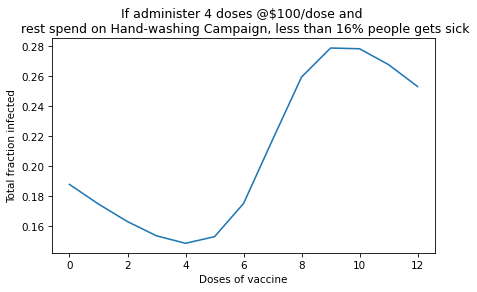

In [38]:
plt.plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='If administer 4 doses @$100/dose and \n rest spend on Hand-washing Campaign, less than 16% people gets sick'
         )

#savefig('figs/chap12-fig04.pdf')

### Exercises

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

24
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24.]
Parameter
0     0.187981
1     0.174677
2     0.162183
3     0.150557
4     0.139864
5     0.130185
6     0.121629
7     0.114351
8     0.108576
9     0.104623
10    0.102922
11    0.103981
12    0.108228
13    0.115612
14    0.125060
15    0.134350
16    0.140974
17    0.143412
18    0.141595
19    0.136419
20    0.129061
21    0.120555
22    0.111658
23    0.102862
24    0.094459
Name: Metric, dtype: float64


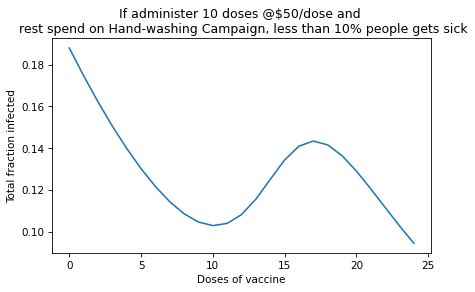

In [39]:
# Solution goes here
num_students = 90
budget = 1200
price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = np.linspace(0, max_doses, max_doses+1, endpoint=True)
print(max_doses)
print(dose_array)

infected_sweep = sweep_doses(dose_array)
print(infected_sweep)
plt.plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='If administer 10 doses @$50/dose and \n rest spend on Hand-washing Campaign, less than 10% people gets sick'
         )

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

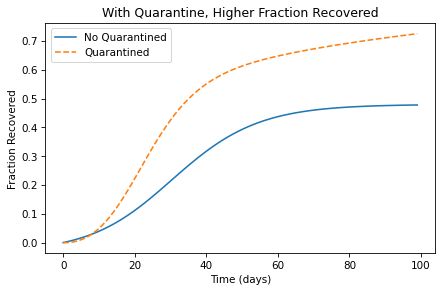

In [40]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)



def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    

    return State(S=s, I=i, R=r)

def run_simulation(system, update_func):
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    return frame


beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)
results = run_simulation(system, update_func)



# Create a system object for the SIR model with quarantine
def make_system_q(beta, gamma):
    init = State(S=89, I=1, R=0, Q=0)  
    init /= sum(init)
    t0 = 0
    t_end = 7 * 14
    return System(init=init, t0=t0, t_end=t_end, beta=beta, gamma=gamma)




# Update function for the SIR model with quarantine
def update_func_qua(state, t, system):
    s, i, r, q = state
    infected = system.beta * i * s
    quarantined = infected
    recovered = system.gamma * q
    
    s -= infected
    i += infected - recovered
    q += quarantined - recovered
    r += recovered
    
    return State(S=s, I=i, R=r, Q=q)

# Run the simulation



beta = 0.333
gamma = 0.25

system = make_system_q(beta, gamma)
results_q= run_simulation(system, update_func_qua)


plt.plot(results.R, '-', label='No Quarantined')
plt.plot(results_q.R, '--', label='Quarantined')

decorate(xlabel='Time (days)',
         ylabel='Fraction Recovered',
         title='With Quarantine, Higher Fraction Recovered')







Without Quarantine:  The recovery is slower and reaches a lower fraction.

With Quarantine: The recovery is faster and reaches a higher fraction.

The effect of quarantine is evident as it leads to a higher recovery rate within the same time frame compared to the scenario without quarantine.